# Europe Travel Reviews

In [1]:
import pandas as pd
import numpy as np

# clustering packages
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# classification packages
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

# visualization packages
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.cluster import InterclusterDistance
from yellowbrick.target import ClassBalance
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.
/Users/sharonkwak/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
# import csv file as dataframe
reviews = pd.read_csv('google_review_ratings.csv')

In [3]:
reviews.head()

,User,Category 1,Category 2,Category 3,Category 4,Category 5,Category 6,Category 7,Category 8,Category 9,...,Category 16,Category 17,Category 18,Category 19,Category 20,Category 21,Category 22,Category 23,Category 24,Unnamed: 25
0,User 1,0.0,0.0,3.63,3.65,5.0,2.92,5.0,2.35,2.33,...,0.59,0.5,0.0,0.5,0.0,0.0,0.0,0.0,0.0,NaN
1,User 2,0.0,0.0,3.63,3.65,5.0,2.92,5.0,2.64,2.33,...,0.59,0.5,0.0,0.5,0.0,0.0,0.0,0.0,0.0,NaN
2,User 3,0.0,0.0,3.63,3.63,5.0,2.92,5.0,2.64,2.33,...,0.59,0.5,0.0,0.5,0.0,0.0,0.0,0.0,0.0,NaN
3,User 4,0.0,0.5,3.63,3.63,5.0,2.92,5.0,2.35,2.33,...,0.59,0.5,0.0,0.5,0.0,0.0,0.0,0.0,0.0,NaN
4,User 5,0.0,0.0,3.63,3.63,5.0,2.92,5.0,2.64,2.33,...,0.59,0.5,0.0,0.5,0.0,0.0,0.0,0.0,0.0,NaN


## Data Cleaning

In [4]:
# drop last row because there are only 2 values compared to 5456 in other columns
reviews.drop('Unnamed: 25', axis=1, inplace=True)

In [5]:
# rename columns
reviews.columns = ['User', 'Churches', 'Resorts', 'Beaches',
                   'Parks', 'Theatres', 'Museums', 'Malls', 'Zoo',
                   'Restaurants', 'Pubs/bars', 'Local services',
                   'Burger/pizza shops', 'Hotels/other lodgings',
                   'Juice bars', 'Art galleries', 'Dance clubs',
                   'Swimming pools', 'Gyms', 'Bakeries', 'Beauty & spas',
                   'Cafes', 'View points', 'Monuments', 'Gardens']

In [6]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5456 entries, 0 to 5455
Data columns (total 25 columns):
User                     5456 non-null object
Churches                 5456 non-null float64
Resorts                  5456 non-null float64
Beaches                  5456 non-null float64
Parks                    5456 non-null float64
Theatres                 5456 non-null float64
Museums                  5456 non-null float64
Malls                    5456 non-null float64
Zoo                      5456 non-null float64
Restaurants              5456 non-null float64
Pubs/bars                5456 non-null float64
Local services           5456 non-null object
Burger/pizza shops       5455 non-null float64
Hotels/other lodgings    5456 non-null float64
Juice bars               5456 non-null float64
Art galleries            5456 non-null float64
Dance clubs              5456 non-null float64
Swimming pools           5456 non-null float64
Gyms                     5456 non-null float64
Ba

In [7]:
# replace discrepant value
reviews.replace('2\t2.', '2.2', inplace=True)

In [8]:
# change value type to float (decimal) from string
reviews['Local services'] = reviews['Local services'].astype(float)

In [9]:
# fill missing values in Burger/pizza shops and Gardens columns with the median
for col in ['Burger/pizza shops', 'Gardens']:
    reviews[col] = reviews[col].fillna(reviews[col].median())

Which type of tourist sites are the most popular overall?

In [10]:
reviews.describe()

,Churches,Resorts,Beaches,Parks,Theatres,Museums,Malls,Zoo,Restaurants,Pubs/bars,...,Art galleries,Dance clubs,Swimming pools,Gyms,Bakeries,Beauty & spas,Cafes,View points,Monuments,Gardens
count,5456.000000,5456.000000,5456.000000,5456.000000,5456.000000,5456.00000,5456.000000,5456.000000,5456.000000,5456.000000,...,5456.000000,5456.000000,5456.000000,5456.000000,5456.000000,5456.000000,5456.000000,5456.000000,5456.000000,5456.000000
mean,1.455720,2.319707,2.489331,2.796886,2.958941,2.89349,3.351395,2.540795,3.126019,2.832729,...,2.206573,1.192801,0.949203,0.822414,0.969811,1.000071,0.965838,1.750537,1.531453,1.560706
std,0.827604,1.421438,1.247815,1.309159,1.339056,1.28240,1.413492,1.111391,1.356802,1.307665,...,1.715961,1.107005,0.973536,0.947911,1.203972,1.193891,0.929853,1.598734,1.316889,1.171655
min,0.000000,0.000000,0.000000,0.830000,1.120000,1.11000,1.120000,0.860000,0.840000,0.810000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.920000,1.360000,1.540000,1.730000,1.770000,1.79000,1.930000,1.620000,1.800000,1.640000,...,0.860000,0.690000,0.580000,0.530000,0.520000,0.540000,0.570000,0.740000,0.790000,0.880000
50%,1.340000,1.905000,2.060000,2.460000,2.670000,2.68000,3.230000,2.170000,2.800000,2.680000,...,1.330000,0.800000,0.740000,0.690000,0.690000,0.690000,0.760000,1.030000,1.070000,1.290000
75%,1.810000,2.682500,2.740000,4.092500,4.312500,3.84000,5.000000,3.190000,5.000000,3.530000,...,4.440000,1.160000,0.910000,0.840000,0.860000,0.860000,1.000000,2.070000,1.560000,1.660000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.00000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


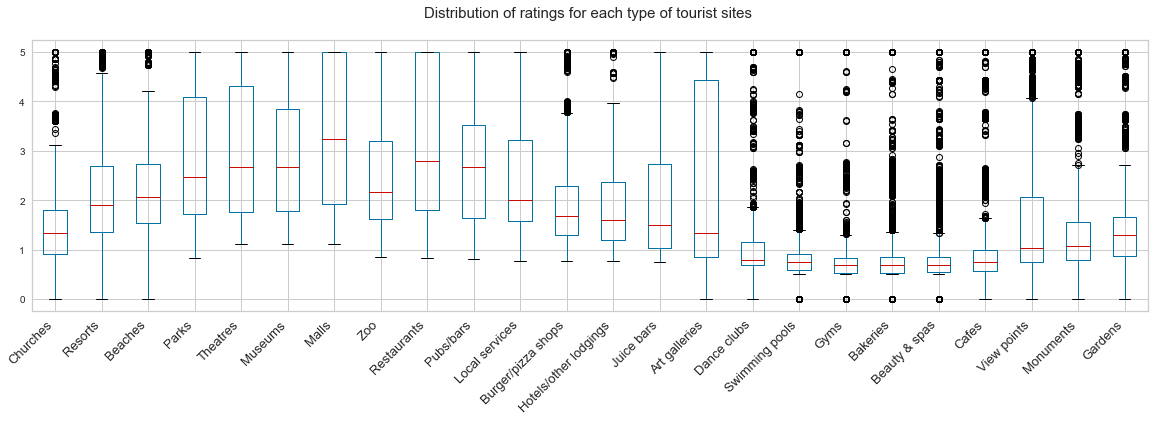

In [11]:
# boxplot of each type of tourist sites
reviews.boxplot(figsize=(20, 5))
plt.xticks(fontsize=13, rotation=45, ha='right')
plt.title('Distribution of ratings for each type of tourist sites \n',
          fontsize=15)
plt.savefig('Images/boxplot.png', bbox_inches='tight')

## Clustering

- What groups can be created based on users' reviews of tourist sites?
- Which type of tourist sites are the most popular for each group of users?
- What type of travel media content should be created for each group of users (e.g. advertisement, leisure/entertainment)?
- Can a review of one type predict the user's review for another type?

In [12]:
# Run PCA on the data and reduce the dimensions to 2
reduced_data = PCA(n_components=2).fit_transform(reviews.drop('User', axis=1))

# transform the reduced data to a dataframe
pca_reviews = pd.DataFrame(reduced_data, columns=['pca1','pca2'])

I chose the K-means clustering algorithm to find center-based clusters, finding a 'consensus' for the whole dataset, which other methods do not do. I was able to use an algorithm that considers the full dataset without worrying about computation efficiency due to the dataset being small with 5456 rows and 25 features.

### Finding the K-value

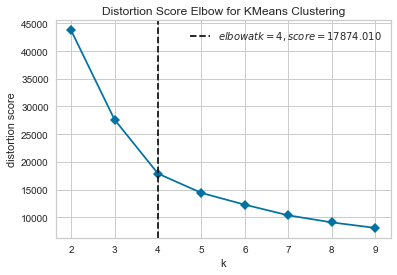

In [13]:
# Instantiate the clustering model and visualizer
model = KMeans(random_state=220)

# create a plot to find the elbow
elbow = KElbowVisualizer(model, k=(2, 10), timings=False)

# Fit the data to the visualizer
elbow.fit(pca_reviews)

# Finalize and render the figure
elbow.show(outpath='Images/kmeans_elbow.png');

As you can see in the above graph, the "elbow" of the graph is at the value 4, so we will proceed using the K-means algorithm with the K-value of 4.

### Applying the algorithm to the data

In [14]:
# kmeans using 4 clusters (elbow from above)
kmeans = KMeans(n_jobs=-1, n_clusters=4, random_state=220)

# fit the data to the model
kmeans.fit(pca_reviews)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=220, tol=0.0001, verbose=0)

### Results

#### Cluster Plot

In [15]:
# calculate the predictions
pred = kmeans.predict(pca_reviews)

# add the predictions to the dataframe
pca_reviews['predictions'] = pred

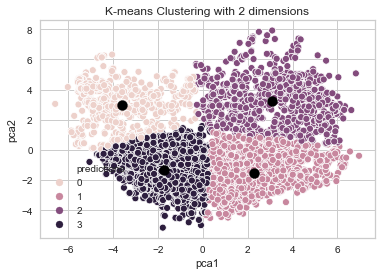

In [16]:
# create scatter plot of the clusters
sns.scatterplot(x="pca1", y="pca2",
                hue=pca_reviews['predictions'],
                data=pca_reviews)

# find the coordinates of the cluster centers
centers = kmeans.cluster_centers_

# mark the cluster centers
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100)

# set title
plt.title('K-means Clustering with 2 dimensions')

plt.savefig('Images/cluster_plot.png', bbox_inches='tight');

#### Interpretation

The data was separated into 4 different groups by the clustering model (0-3) as you can see in the above cluster plot.

Group 0:
- fewest values
- highest average ratings for juice bars (4.6), art galleries (4.2), and hotels/other lodgings (3.8)
- lowest average rating for monuments (0.731), cafes (0.733), and viewpoints (0.76)

Group 1:
- theatres had highest average ratings for theatres (4.3), with parks (4.1) and museums following (3.6)
- gyms had lowest average rating (0.57), with bakeries (0.59) and pools (0.7) following

Group 2:
- viewpoints had highest average rating (2.8), with resorts (2.7) and gardens (2.6) following
- burger/pizza shops had lowest average rating (1.4), with hotels/other lodgings (1.5 and zoos following

Group 3:
- most values
- highest average rating for malls (4.2), restaurants, and pubs/bars
- lowest average rating for gyms (0.5), bakeries, and beauty/spas

In [17]:
# add predictions to the original dataframe
reviews['Predictions'] = pred

In [18]:
# number of values in each group
reviews['Predictions'].value_counts()

3    2173
1    1591
2     931
0     761
Name: Predictions, dtype: int64

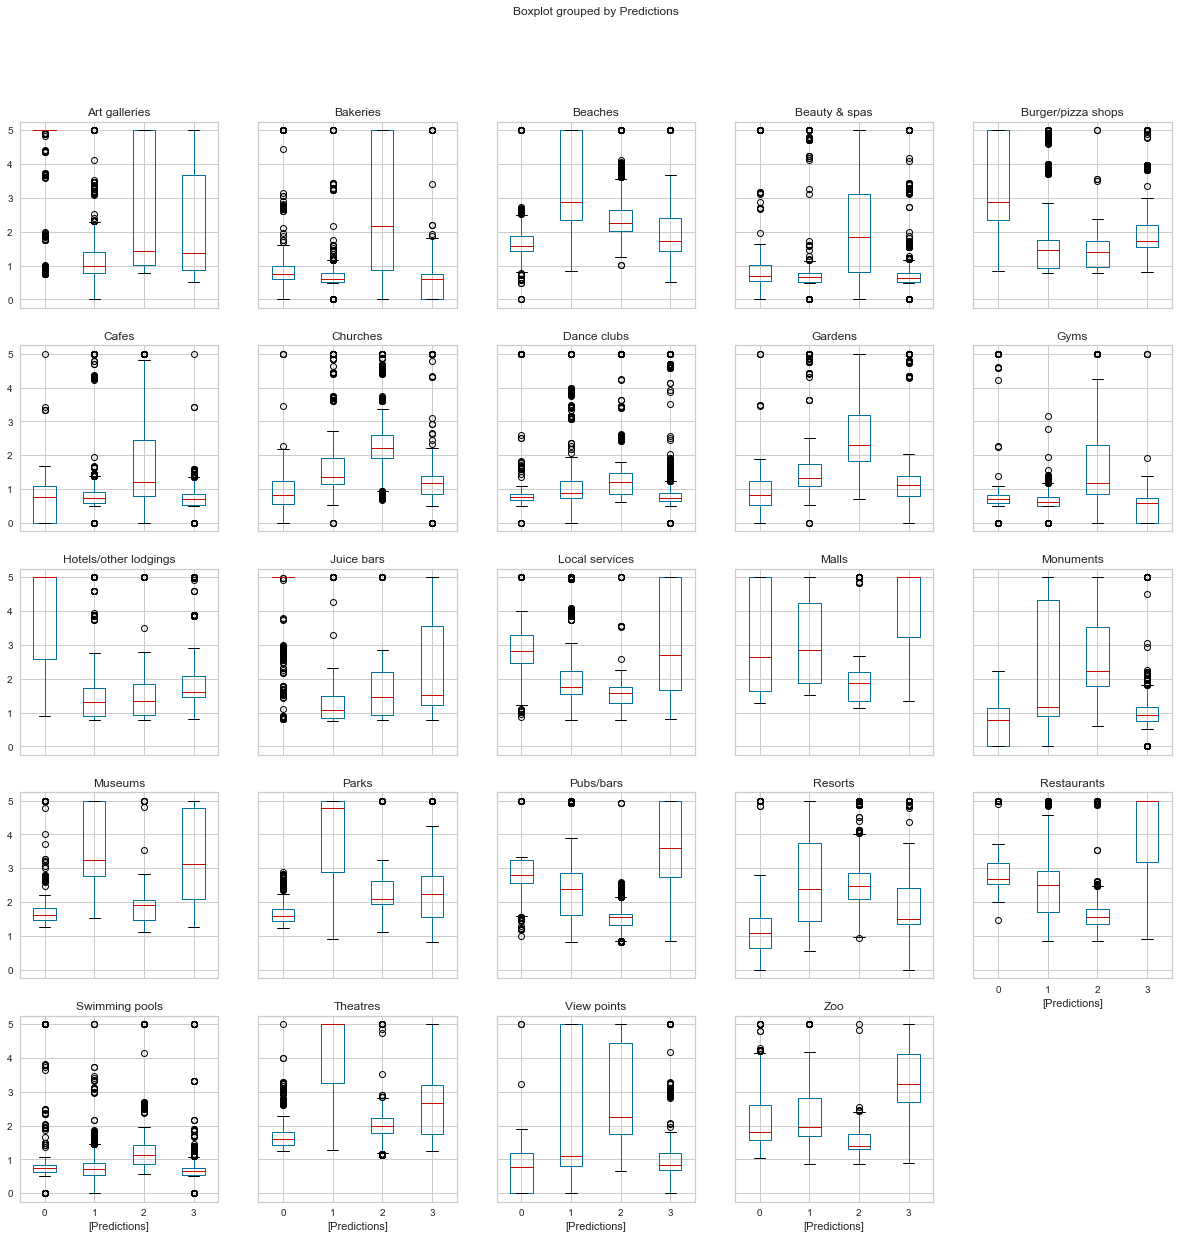

In [19]:
# boxplot of the clusters by each type of tourist sites
reviews.boxplot(figsize=(20, 20), by='Predictions');

In [20]:
# average of ratings for each type of tourist site grouped by the clusters
types = reviews.groupby('Predictions').mean().T.reset_index()

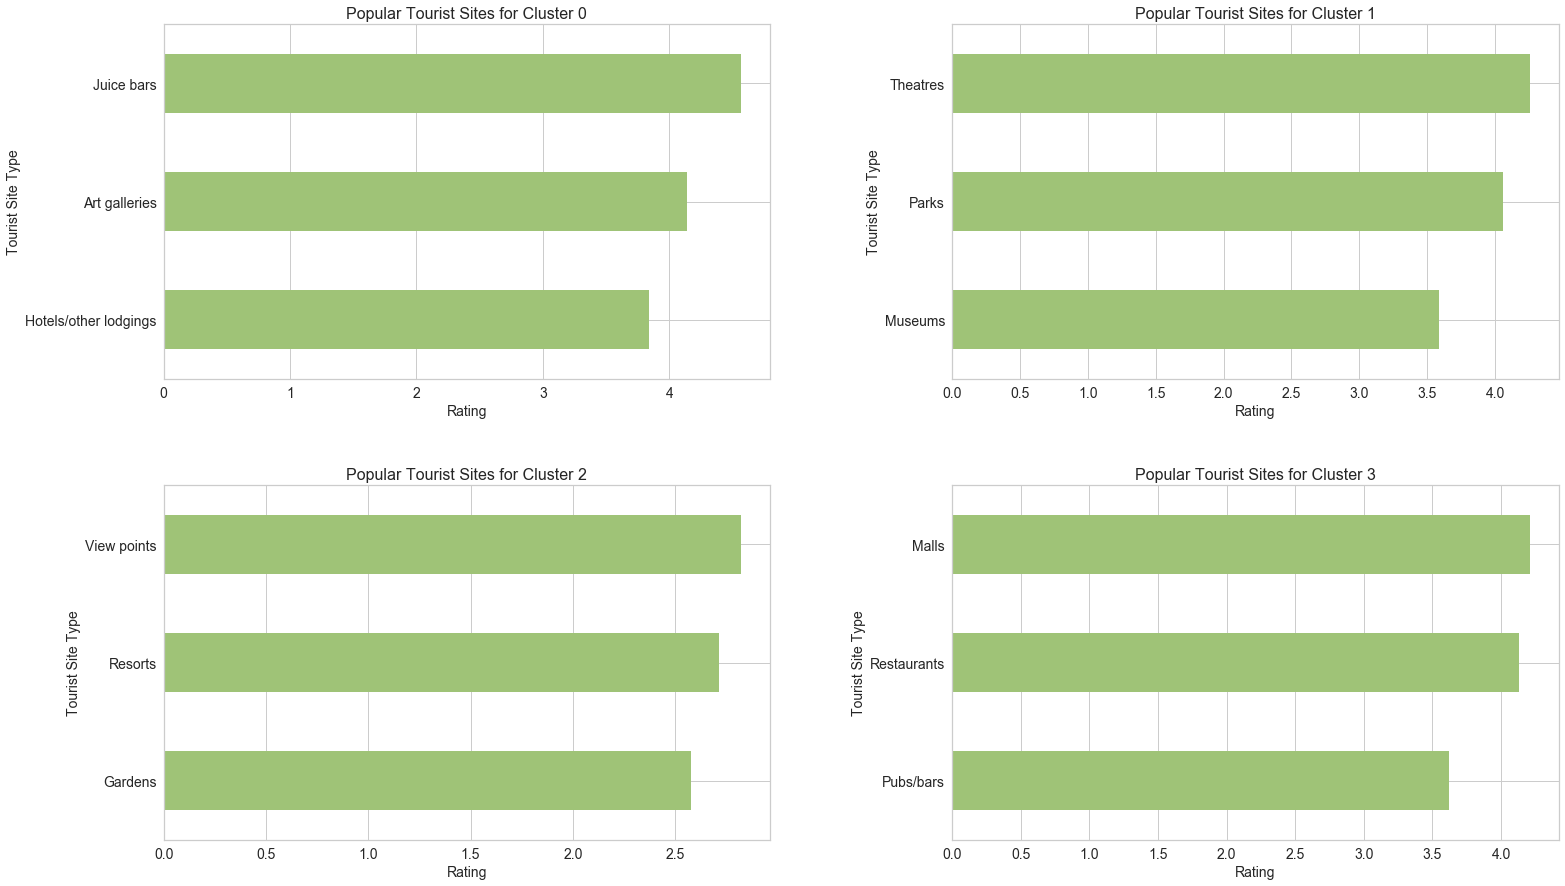

In [22]:
fig, ax = plt.subplots(2, 2, figsize=(25, 15))
# graph top 5 sites
for i, col in enumerate([0, 1, 2, 3]):
    # plot bar graph of site types and their ratings
    types.sort_values(col).iloc[-3:].plot(x='index', y=col, kind='barh',
                                         legend=False, ax=ax[i//2, i % 2],
                                         color='g')
    # create title for each plot
    ax[i//2, i % 2].set_title(f'Popular Tourist Sites for Cluster {col}',
                              fontsize=16)
    # fontsize for x and y ticks
    ax[i//2, i % 2].tick_params(labelsize=14)
    # x-axis label
    ax[i//2, i % 2].set_xlabel('Rating', fontsize=14)
    # y-axis label
    ax[i//2, i % 2].set_ylabel('Tourist Site Type', fontsize=14)
    
# increase vertical space between subplots
plt.subplots_adjust(wspace=0.3, hspace=0.3)

# save figure to current path
plt.savefig('Images/popular_sites.png', bbox_inches='tight');

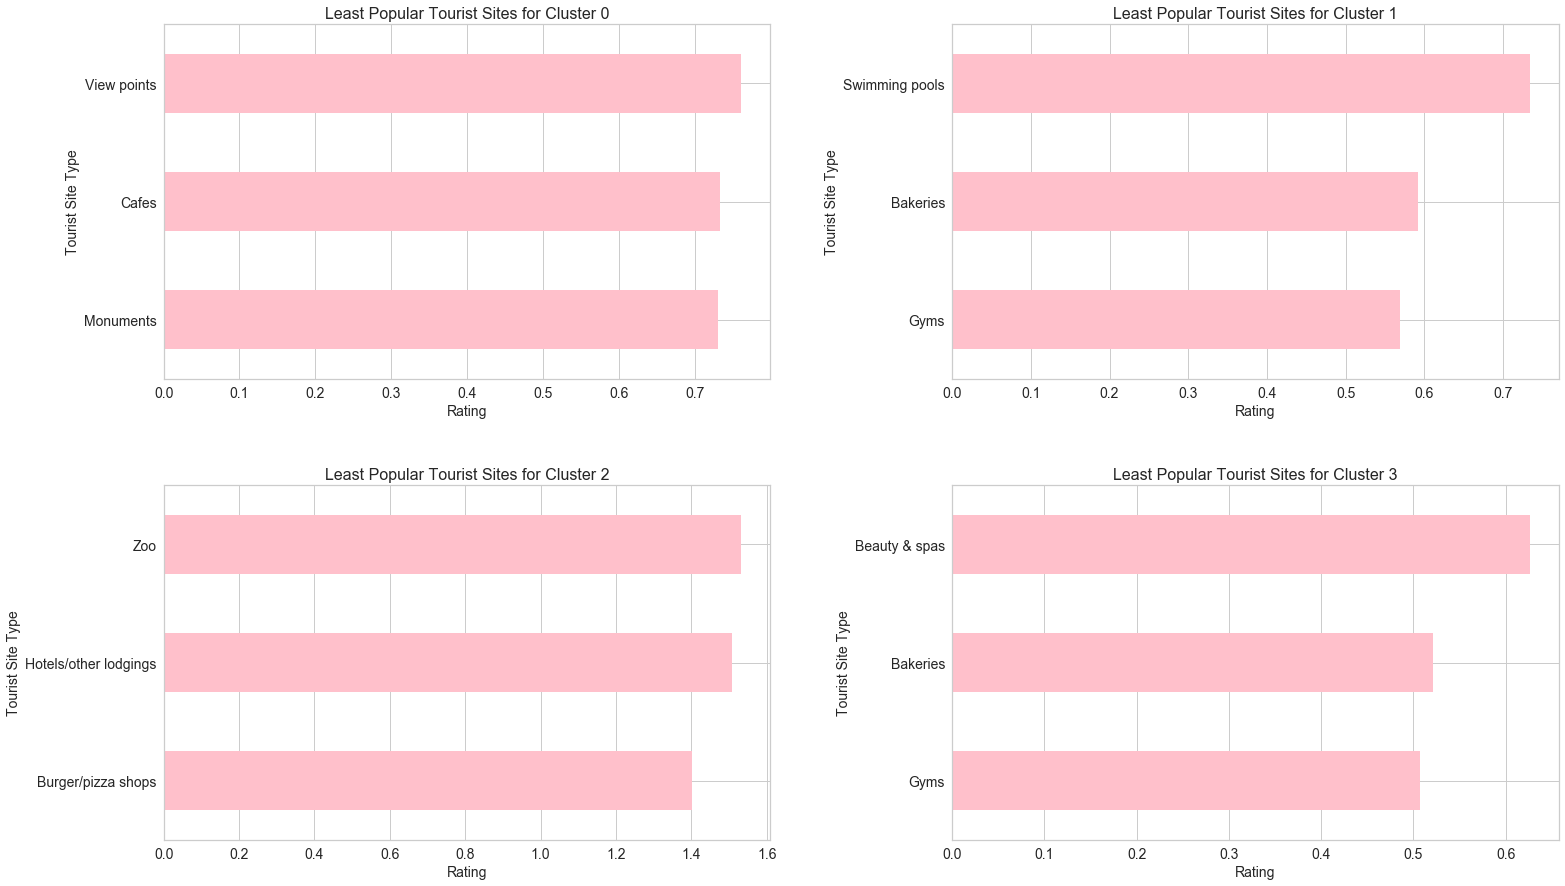

In [23]:
fig, ax = plt.subplots(2, 2, figsize=(25, 15))
# graph 5 least popular  sites
for i, col in enumerate([0, 1, 2, 3]):
    # plot bar graph of site types and their ratings
    types.sort_values(col).iloc[:3].plot(x='index', y=col, kind='barh',
                                         legend=False, ax=ax[i//2, i % 2],
                                        color='pink')
    # create title for each plot
    ax[i//2, i % 2].set_title(f'Least Popular Tourist Sites for Cluster {col}',
                              fontsize=16)
    # fontsize for x and y ticks
    ax[i//2, i % 2].tick_params(labelsize=14)
    # x-axis label
    ax[i//2, i % 2].set_xlabel('Rating', fontsize=14)
    # y-axis label
    ax[i//2, i % 2].set_ylabel('Tourist Site Type', fontsize=14)
    
# increase vertical space between subplots
plt.subplots_adjust(wspace=0.3, hspace=0.3)

# save figure to current path
plt.savefig('Images/least_popular_sites.png', bbox_inches='tight');

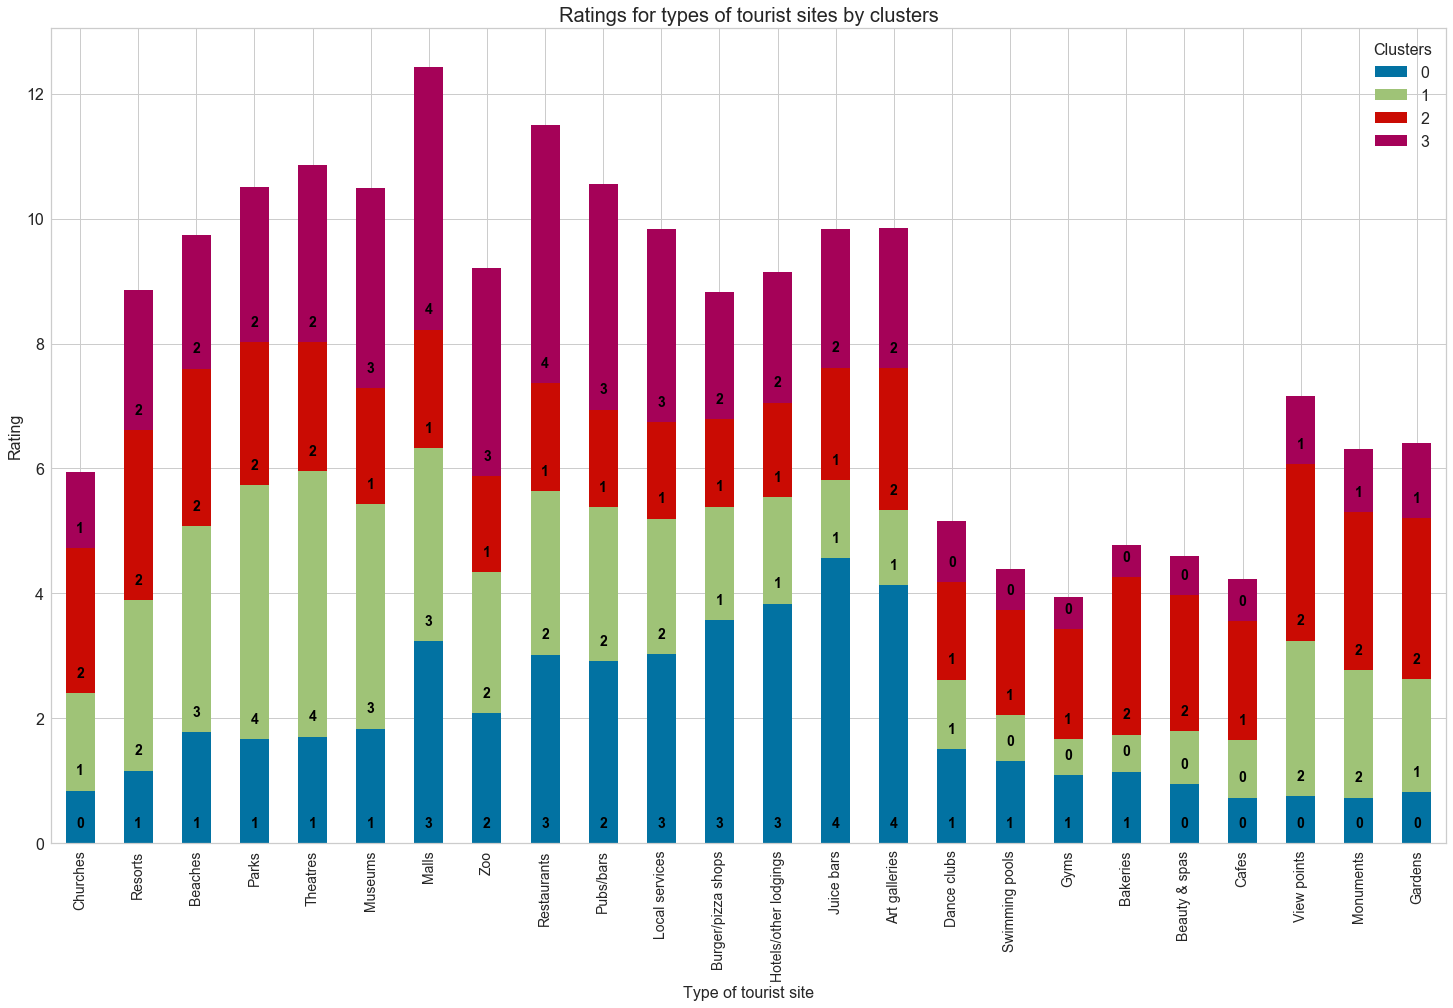

In [24]:
# stacked bar plot of ratings
# for each type of tourist site
# grouped by clusters
ax = types.plot('index', [0, 1, 2, 3], kind='bar',
          figsize=(25, 15), stacked=True)

# for each bar, label each stack
# with the average rating for each cluster
for lbl in ax.patches:
    ax.annotate("{:.00f}".format(int(lbl.get_height())),
                (lbl.get_x()+0.25, lbl.get_y()+0.2), verticalalignment='bottom',
                horizontalalignment='center', fontsize=14, weight='bold', color='black')
    
# set title for the plot
plt.title('Ratings for types of tourist sites by clusters',
         fontsize=20)

# set x- and y-axis labels
plt.xlabel('Type of tourist site', fontsize=16)
plt.ylabel('Rating', fontsize=16)

# change font size for x- and y-ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=16)

# set title for legends and change fontsize
plt.legend(title='Clusters', fontsize=16,
           title_fontsize=16)

# save figure to current path
plt.savefig('Images/cluster_ratings.png', bbox_inches='tight');

### Classification

- Can a review of one type predict the user's review for another type?
- Ratings for which type of tourist sites have the most impact on the group assignments?

#### Data Pre-processing

In [25]:
# set feature and target values
X = reviews.drop(['User', 'Predictions'], axis=1)
y = reviews['Predictions']

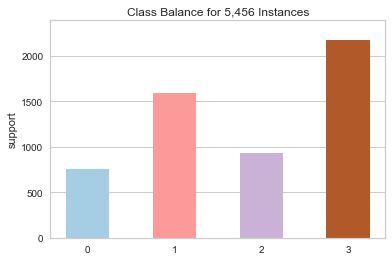

In [26]:
# define classes from the labels created from clustering
classes = [0, 1, 2, 3]

# observe the number of values for each class
class_balance = ClassBalance(labels=classes, colormap='Paired')

# fit the Class Balance to the target value
class_balance.fit(y)

# finalize and render the figure
class_balance.show(outpath='Images/class_balance.png');

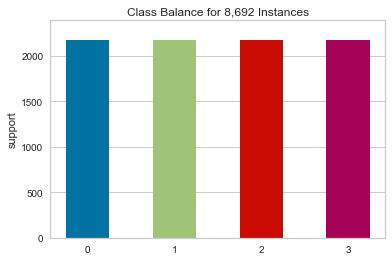

In [27]:
# apply oversampling method to balance the classes
smote = SMOTE(random_state=220)

# fit SMOTE to the data and resample
X, y = smote.fit_resample(X, y)

# observe the number of values for each class after oversampling
class_balance = ClassBalance(labels=classes)

# fit the Class Balance to the target value
class_balance.fit(y)

# finalize and render the figure
class_balance.show(outpath='Images/smote_balance.png');

In [28]:
# split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=220)

#### Modeling

With a small dataset, I decided to start out with Linear Support Vector Classifier (Linear SVC) due to it being known to work well on small number of examples and known for fast training times. It also works well with continuous features, and all of the features of this dataset are continuous.

In [29]:
# define the parameter grid for SVC
grid_svm = {'C': [1, 10, 100],
            'class_weight': ['balanced', None],
            'kernel': ['linear']}

# run gridsearch with SVC
gs_svm = GridSearchCV(estimator=SVC(random_state=220),
                      param_grid=grid_svm,
                      scoring='f1_macro',
                      cv=5, verbose=1, n_jobs=-1)

# fit the training set to the model
svm = gs_svm.fit(X_train, y_train)

# show the best parameters
print('Best params:', svm.best_params_)

# show the training score of the model with the best parameters
print('Train f1-score: %.3f' % svm.best_score_)

# show the test score of the model with the best parameters
print('Test f1-score: %.3f' % svm.score(X_test, y_test))

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best params: {'C': 10, 'class_weight': None, 'kernel': 'linear'}
Train f1-score: 0.995
Test f1-score: 0.996


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.2s finished


Even though the SVC model performed well as you can see above, I wanted to use other models to double check that there aren't huge discrepancies in the model performances. The following models (KNN, LightGBM, and Random Forest which isn't shown below) are the models I would have used subsequently for other datasets as well if SVC did not perform well.

In [30]:
# define the parameter grid for KNN
grid_knn = {'n_neighbors': [2, 4, 8]}

# run grid search with KNN
gs_knn = GridSearchCV(estimator=KNeighborsClassifier(),
                      param_grid=grid_knn,
                      scoring='f1_macro',
                      cv=5, verbose=1, n_jobs=-1)

# fit the training set to the model
knn = gs_knn.fit(X_train, y_train)

# show the best parameters
print('Best params:', knn.best_params_)

# show the training score of the model with the best parameters
print('Train f1-score: %.3f' % knn.best_score_)

# show the test score of the model with the best parameters
print('Test f1-score: %.3f' % knn.score(X_test, y_test))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best params: {'n_neighbors': 2}
Train f1-score: 0.966
Test f1-score: 0.969


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.0s finished


In [31]:
# define the parameter grid for LightGBM
grid_lgb = {'learning_rate': [0.01, 0.025, 0.1],
            'max_depth': [9, 12, 15],
            'min_child_weight': [1, 3],
            'subsample': [0.1, 0.3]}

# run grid search with LightGBM
gs_lgb = GridSearchCV(estimator=lgb.LGBMClassifier(random_state=220),
                      param_grid=grid_lgb,
                      scoring='f1_macro',
                      cv=5, verbose=1, n_jobs=-1)

# fit the training set to the model
lgb = gs_lgb.fit(X_train, y_train)

# show the best parameters
print('Best params:', lgb.best_params_)

# show the training score of the model with the best parameters
print('Train f1-score: %.3f' % lgb.best_score_)

# show the test score of the model with the best parameters
print('Test f1-score: %.3f' % lgb.score(X_test, y_test))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  1.3min finished


Best params: {'learning_rate': 0.1, 'max_depth': 12, 'min_child_weight': 1, 'subsample': 0.1}
Train f1-score: 0.975
Test f1-score: 0.978


#### Results

##### Performance of the classifier

After running Support Vector Classifiers (SVC), KNeighbors Classifier (KNN), and LightGBM, SVC came out to be the best performing model with an f1-score of 99.6%. As you can see below in the confusion matrix, only 7 values were misidentified while the others were all correctly identified.

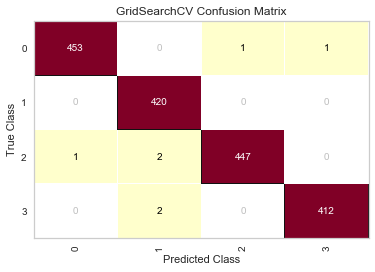

In [32]:
# The ConfusionMatrix visualizer taxes a model
cm = ConfusionMatrix(svm, classes=[0,1,2,3])

# Fit the training set to the model
cm.fit(X_train, y_train)

# calculate the predictions
cm.score(X_test, y_test)

# How did we do?
cm.show(outpath='Images/confusion_matrix.png');

#### Interpretation

Through observing the coefficients from the SVC model, juice bars, theatres, and art galleries had the highest absolute coefficients and thus more impact on identifying the groups. Juice bars and art galleries had a positive impact (the higher the ratings, the higher the cluster group number). Theatres, on the other hand, had a negative impact (the lower the ratings, the higher the cluster group number).

In [33]:
# create a dataframe of the coefficients of each feature
feat_imp_svm = pd.DataFrame(zip(reviews.drop(['User', 'Predictions'], axis=1),
                                svm.best_estimator_.coef_[0]),
                            columns=['Feature', 'Coefficient'])

# create a column for the absolute coefficient
# to observe the features with the most impact
feat_imp_svm['Absolute Coefficient'] = feat_imp_svm.Coefficient.apply(lambda x: abs(x))

# sort the dataframe by the absolute coefficient
feat_imp_svm = feat_imp_svm.sort_values(by='Absolute Coefficient')

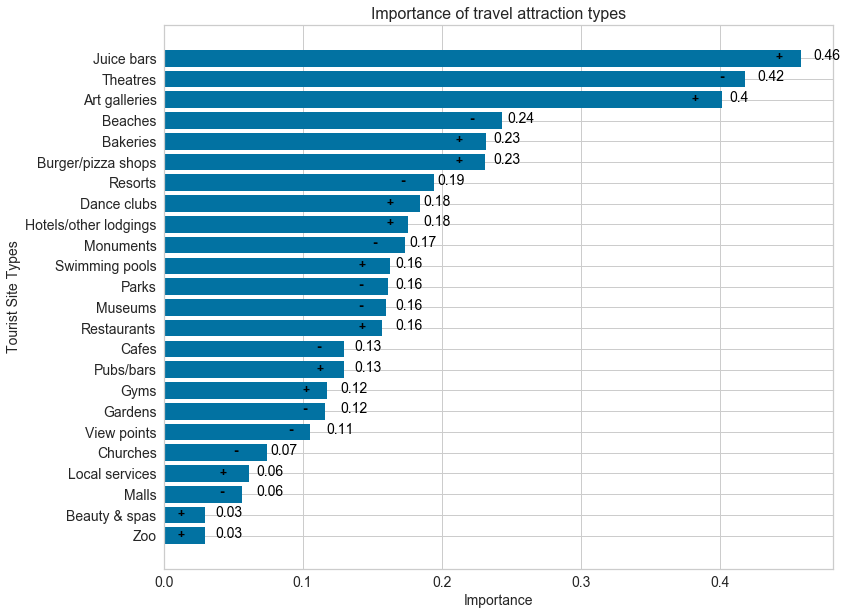

In [34]:
# set figure size
plt.figure(figsize=(12, 10))

# plot a horizontal bar graph of the features and their coefficients
plt.barh(feat_imp_svm['Feature'],
         feat_imp_svm['Absolute Coefficient'],
         align='center')

plt.xlabel('Importance', fontsize=14)
plt.ylabel('Tourist Site Types', fontsize=14)
plt.tick_params(labelsize=14)

# create a list of coefficients rounded to the hundredths
coefs = feat_imp_svm['Coefficient'].apply(lambda x: round(x, 2))
# create a label at the end of each bar
for i, v in enumerate(coefs):
        # label for absolute coefficient value
        plt.text(round(np.abs(v), 2) + 0.007, i - 0.1,
                 str(np.abs(round(v, 2))),
                 color='black',
                 fontsize=14)
        # label for positive sign for positive coefficients
        if v > 0:
            plt.text(v - 0.02, i - 0.1, '+',
                     color='black',
                     fontsize=12,
                     fontweight='bold')
        # label for negative sign for negative coefficients
        else:
            plt.text(np.abs(v) - 0.02, i - 0.1, '-',
                     color='black',
                     fontsize=14,
                     fontweight='bold')

# set title of graph
plt.title('Importance of travel attraction types', fontsize=16)

plt.savefig('Images/feat_imp.png', bbox_inches='tight');